1) PRIMERO SE REALIZA LA CALIBRACIÓN DE LA CÁMARA.

Obtiene los parámetros internos de la camara para (mtx, dist) que serán usados para corregir la distorsión.
    1.1.- Configuración del patrón de tablero:
         - Define el tamaño del patrón de ajedrez (pattern_size).
         - Define el tamaño real de cada cuadro del tablero (square_size), importante para escala.

    1.2.- Generación de puntos 3D reales (objp):
         - Se crea una matriz con las coordenadas físicas del tablero en el espacio real (X, Y, Z=0).

    1.3.- Inicialización de listas:
        - objpoints: guardará los puntos 3D reales.

        - imgpoints: guardará los puntos 2D detectados en cada imagen.
    
    1.4.- Carga de imágenes del tablero:
        - Se leen todas las imágenes con patrón de ajedrez desde la carpeta Images/.

    1.5.- Búsqueda de esquinas:
        - En cada imagen, se detectan las esquinas internas del tablero con cv2.findChessboardCorners.
        - Si se detectan:
            - Se refinan las esquinas con cv2.cornerSubPix.
            - Se guardan en las listas objpoints y imgpoints.

    1.6.- Calibración de la cámara:
        - Con los puntos recolectados, se llama a cv2.calibrateCamera.
        - Se obtienen la matriz de cámara (mtx) y los coeficientes de distorsión (dist).
        - mtx y dist: Se usan para corregir la distorsión óptica que genera la lente de la cámara (curvaturas, desplazamientos).

    1.7. -Guardado de parámetros:
        - Se guardan los resultados en el archivo parametros_calibracion.npz.

In [1]:
import os
import cv2
import numpy as np
import glob

# === CONFIGURACIÓN DEL PATRÓN ===
pattern_size = (9, 6)       # Número de esquinas internas (columnas, filas)
square_size = 25            # Tamaño real de un cuadro del tablero (en mm, cm, etc.)

# === CREAR OBJPOINTS (coordenadas 3D del patrón) ===
objp = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
objp *= square_size

objpoints = []
imgpoints = []
image_shape = None

# === CARGAR IMÁGENES DE TABLERO ===
images = glob.glob('./Images/*.jpg')  # Asegúrate de que estén en esta carpeta

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

    if ret:
        if image_shape is None:
            image_shape = gray.shape[::-1]

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

        objpoints.append(objp)
        imgpoints.append(corners)

# === CALIBRAR CÁMARA ===
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)

# === GUARDAR PARÁMETROS ===
np.savez('parametros_calibracion.npz', mtx=mtx, dist=dist)
print("✅ Parámetros de calibración guardados en 'parametros_calibracion.npz'")


✅ Parámetros de calibración guardados en 'parametros_calibracion.npz'


CÓDIGO PARA VISUALIZAR LA IMAGEN CON LOS PARÁMETROS DE CALIBRACIÓN

In [2]:
import cv2
import numpy as np

# === Cargar parámetros calibrados ===
data = np.load('parametros_calibracion.npz')
mtx, dist = data['mtx'], data['dist']
print("✅ Calibración completada. Parámetros guardados en 'parametros_calibracion.npz'.")

# === Cargar imagen a corregir ===
img = cv2.imread('inclinada1.jpg')
h, w = img.shape[:2]

# === Corregir distorsión ===
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)

# === Mostrar resultado ===
cv2.imshow('Original', img)
cv2.imshow('Corregida', undistorted)
cv2.waitKey(0)
cv2.destroyAllWindows()

✅ Calibración completada. Parámetros guardados en 'parametros_calibracion.npz'.


NO MUESTRA BIEN LA IMAGEN DE HOMOGRAFÍA:

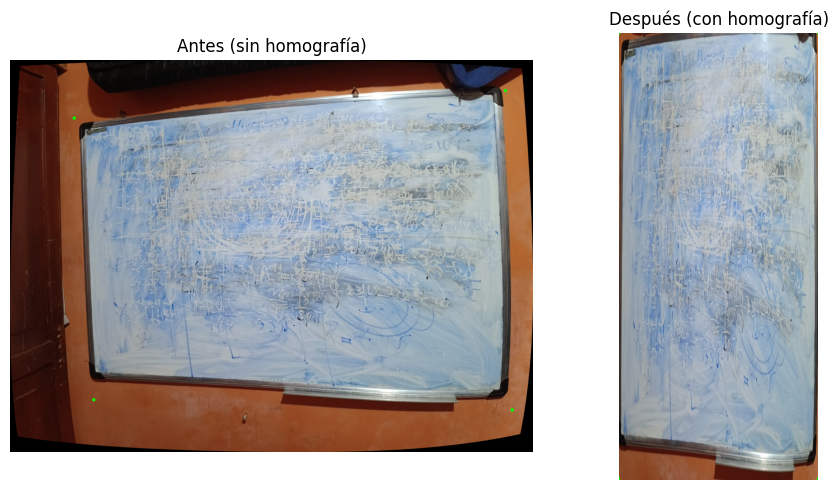

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Cargar calibración ===
data = np.load('parametros_calibracion.npz')
mtx, dist = data['mtx'], data['dist']

# === Cargar imagen y corregir distorsión ===
img = cv2.imread('corregir3.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)

# === Seleccionar 4 puntos ===
points = []
def seleccionar_puntos(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        cv2.circle(undistorted, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Selecciona 4 puntos", undistorted)

cv2.namedWindow('Selecciona 4 puntos', cv2.WINDOW_NORMAL)
cv2.imshow("Selecciona 4 puntos", undistorted)
cv2.setMouseCallback("Selecciona 4 puntos", seleccionar_puntos)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(points) != 4:
    print("❌ Selecciona exactamente 4 puntos.")
    exit()

# === Definir rectángulo destino y aplicar homografía ===
src_pts = np.array(points, dtype=np.float32)
#width, height = 400, 900  # Ajusta al tamaño final que desees
dst_pts = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

H = cv2.getPerspectiveTransform(src_pts, dst_pts)
rectificada = cv2.warpPerspective(undistorted, H, (width, height))

# === Mostrar antes y después ===
undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
rectificada_rgb = cv2.cvtColor(rectificada, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(undistorted_rgb)
plt.title("Antes (sin homografía)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rectificada_rgb)
plt.title("Después (con homografía)")
plt.axis('off')
plt.tight_layout()
plt.show()

2) CÓDIGO CON BUENA HOMOGRAFÍA:
Este código permite rectificar una imagen inclinada mediante homografía, después de haberla corregido por distorsión.
    2.1.- Carga de parámetros de calibración:
        - Recupera mtx y dist del archivo guardado.

    2.2.- Carga de la imagen real:
        - Carga la imagen en la que deseas corregir la perspectiva.

    2.3.- Corrección de distorsión óptica:
        - Aplica cv2.undistort para eliminar la distorsión de lente usando mtx y dist.

    2.4.- Selección manual de 4 puntos:
        - Muestra la imagen y permite al usuario hacer clic en las 4 esquinas del objeto a rectificar.
        - Guarda los puntos seleccionados en la lista points.

    2.5.- Cálculo automático del tamaño del destino:
        - Usa la distancia entre los puntos seleccionados para calcular el ancho y alto del objeto.
        - Esto evita que la imagen quede estirada o deformada.

    2.6.- Cálculo de la homografía:
        - Usa cv2.getPerspectiveTransform para obtener la matriz de homografía H entre los puntos seleccionados (fuente) y el rectángulo destino.
        - Aplica la transformación con cv2.warpPerspective.
        - Se calcula únicamente a partir de 4 puntos fuente (src_pts) y 4 puntos destino (dst_pts).
        - No requiere información de la lente ni de la cámara.
        - Solo transforma un plano a otro plano.
    
    2.7.- Visualización comparativa:
        - Muestra dos imágenes:
            -La original corregida (sin distorsión, pero aún en ángulo).
            - La imagen rectificada (como si fuera tomada de frente).


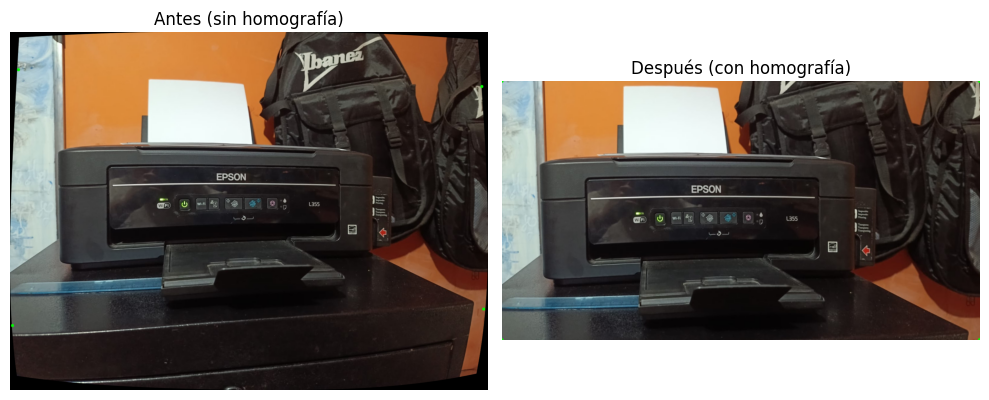

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Cargar calibración ===
data = np.load('parametros_calibracion.npz')
mtx, dist = data['mtx'], data['dist']

# === Cargar imagen y corregir distorsión ===
img = cv2.imread('corregir2.jpg')
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)

# === Selección de puntos ===
points = []
def seleccionar_puntos(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        cv2.circle(undistorted, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Selecciona 4 puntos", undistorted)

cv2.namedWindow('Selecciona 4 puntos', cv2.WINDOW_NORMAL)
cv2.imshow("Selecciona 4 puntos", undistorted)
cv2.setMouseCallback("Selecciona 4 puntos", seleccionar_puntos)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(points) != 4:
    print("❌ Debes seleccionar exactamente 4 puntos.")
    exit()

# === Puntos fuente ===
src_pts = np.array(points, dtype=np.float32)

# === Calcular ancho y alto automáticamente ===
def distancia(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

width_top    = distancia(points[0], points[1])
width_bottom = distancia(points[3], points[2])
height_left  = distancia(points[0], points[3])
height_right = distancia(points[1], points[2])

width  = int(max(width_top, width_bottom))
height = int(max(height_left, height_right))

# === Crear puntos destino con tamaño calculado ===
dst_pts = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

# === Calcular homografía y transformar ===
H = cv2.getPerspectiveTransform(src_pts, dst_pts)
rectificada = cv2.warpPerspective(undistorted, H, (width, height))

# === Mostrar antes y después ===
undistorted_rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)
rectificada_rgb = cv2.cvtColor(rectificada, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(undistorted_rgb)
plt.title("Antes (sin homografía)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rectificada_rgb)
plt.title("Después (con homografía)")
plt.axis('off')
plt.tight_layout()
plt.show()

CÓDIGO SIN CORRECIÓN DE DISTORSIÓN, SOLO SE HACE LA HOMOGRAFÍA EN LA IMAGEN ORIGINAL:

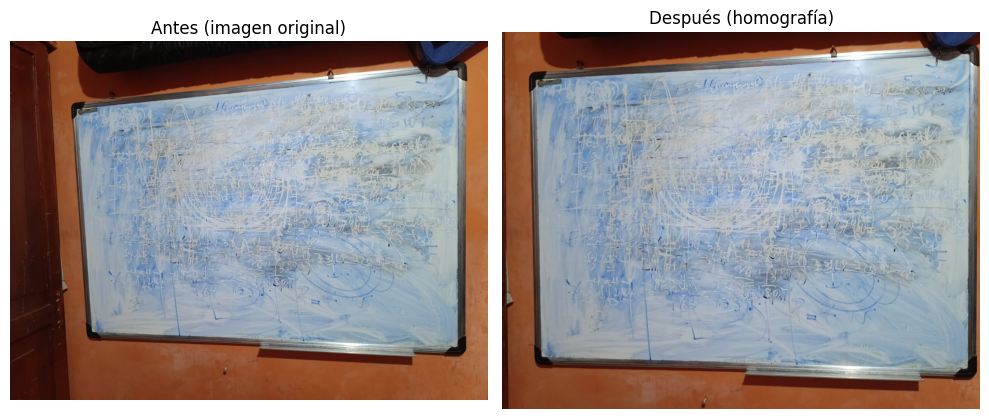

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Cargar imagen (sin corrección de distorsión) ===
img = cv2.imread('corregir3.jpg')
if img is None:
    raise FileNotFoundError("No se pudo cargar 'corregir.jpg'.")

# Trabajaremos sobre una copia para dibujar los clics
vis = img.copy()

# === Selección de puntos ===
points = []

def seleccionar_puntos(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        cv2.circle(vis, (x, y), 5, (0, 255, 0), -1)
        cv2.imshow("Selecciona 4 puntos (TL, TR, BR, BL o en cualquier orden)", vis)

cv2.namedWindow('Selecciona 4 puntos (TL, TR, BR, BL o en cualquier orden)', cv2.WINDOW_NORMAL)
cv2.imshow("Selecciona 4 puntos (TL, TR, BR, BL o en cualquier orden)", vis)
cv2.setMouseCallback("Selecciona 4 puntos (TL, TR, BR, BL o en cualquier orden)", seleccionar_puntos)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(points) != 4:
    print("❌ Debes seleccionar exactamente 4 puntos.")
    raise SystemExit

# === Ordenar puntos automáticamente: TL, TR, BR, BL ===
pts = np.array(points, dtype=np.float32)
# Orden por suma y diferencia
s = pts.sum(axis=1)
diff = np.diff(pts, axis=1).ravel()

tl = pts[np.argmin(s)]
br = pts[np.argmax(s)]
tr = pts[np.argmin(diff)]
bl = pts[np.argmax(diff)]

src_pts = np.array([tl, tr, br, bl], dtype=np.float32)

# === Calcular ancho y alto automáticamente ===
def distancia(p1, p2):
    return np.linalg.norm(np.array(p1, dtype=np.float32) - np.array(p2, dtype=np.float32))

width_top    = distancia(tl, tr)
width_bottom = distancia(bl, br)
height_left  = distancia(tl, bl)
height_right = distancia(tr, br)

width  = max(int(round(max(width_top, width_bottom))), 1)
height = max(int(round(max(height_left, height_right))), 1)

# === Puntos destino con tamaño calculado ===
dst_pts = np.array([
    [0, 0],
    [width - 1, 0],
    [width - 1, height - 1],
    [0, height - 1]
], dtype=np.float32)

# === Calcular homografía y transformar ===
H = cv2.getPerspectiveTransform(src_pts, dst_pts)
rectificada = cv2.warpPerspective(img, H, (width, height))

# === Mostrar antes y después ===
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rectificada_rgb = cv2.cvtColor(rectificada, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Antes (imagen original)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rectificada_rgb)
plt.title("Después (homografía)")
plt.axis('off')

plt.tight_layout()
plt.show()

CÓDIGO QUE RECTIFICA TODA LA IMAGEN DE MANERA GLOBAL:

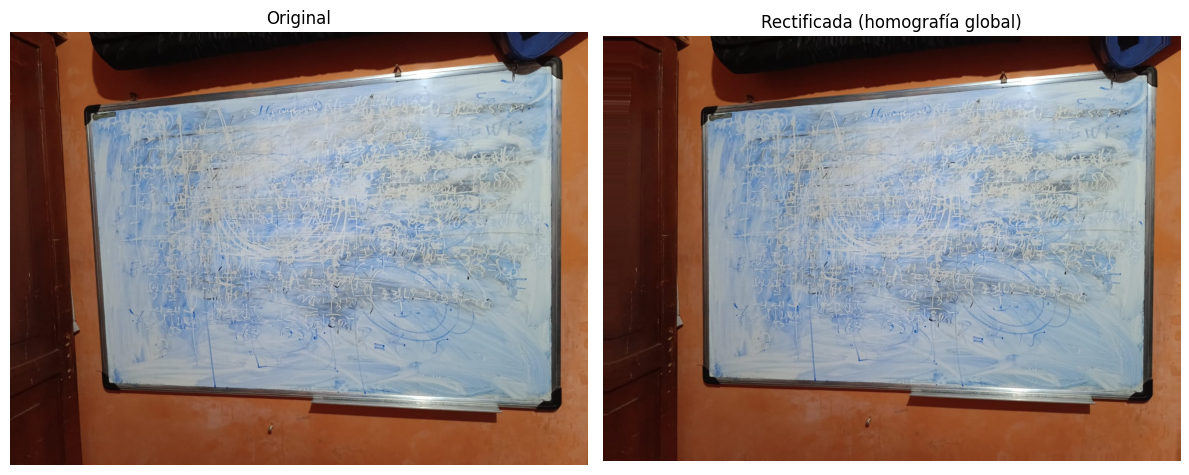

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('corregir3.jpg')
if img is None:
    raise FileNotFoundError("No se pudo cargar 'corregir3.jpg'.")
vis = img.copy()

# --- Selección de 4 puntos en el mismo plano ---
points = []
def on_click(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        cv2.circle(vis, (x, y), 5, (0,255,0), -1)
        cv2.imshow("Haz clic en 4 esquinas del mismo plano", vis)

cv2.namedWindow("Haz clic en 4 esquinas del mismo plano", cv2.WINDOW_NORMAL)
cv2.imshow("Haz clic en 4 esquinas del mismo plano", vis)
cv2.setMouseCallback("Haz clic en 4 esquinas del mismo plano", on_click)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(points) != 4:
    raise SystemExit("❌ Debes seleccionar exactamente 4 puntos.")

# --- Ordena puntos (TL, TR, BR, BL) ---
pts = np.array(points, dtype=np.float32)
s = pts.sum(axis=1); d = np.diff(pts, axis=1).ravel()
tl, br = pts[np.argmin(s)], pts[np.argmax(s)]
tr, bl = pts[np.argmin(d)], pts[np.argmax(d)]
src_pts = np.array([tl, tr, br, bl], dtype=np.float32)

# --- Elige un tamaño destino con la proporción del cuadrilátero ---
def dist(a,b): return np.linalg.norm(a-b)
w = int(round(max(dist(tl,tr), dist(bl,br))))
h = int(round(max(dist(tl,bl), dist(tr,br))))
w = max(w,1); h = max(h,1)

dst_pts = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], dtype=np.float32)

# --- Homografía que vuelve frontal ese plano ---
H = cv2.getPerspectiveTransform(src_pts, dst_pts)

# --- Warpear la IMAGEN COMPLETA (no solo el parche) ---
h_img, w_img = img.shape[:2]
corners = np.array([[0,0],[w_img-1,0],[w_img-1,h_img-1],[0,h_img-1]], dtype=np.float32)
# Transformar esquinas de la imagen
corners_t = cv2.perspectiveTransform(corners[None, :, :], H)[0]

min_xy = corners_t.min(axis=0)
max_xy = corners_t.max(axis=0)

# Trasladar para evitar coords negativas
Tx, Ty = -min_xy[0], -min_xy[1]
T = np.array([[1,0,Tx],
              [0,1,Ty],
              [0,0, 1 ]], dtype=np.float32)

W = int(np.ceil(max_xy[0] - min_xy[0]))
Hout = int(np.ceil(max_xy[1] - min_xy[1]))

rectificada_full = cv2.warpPerspective(img, T @ H, (W, Hout),
                                       flags=cv2.INTER_CUBIC,
                                       borderMode=cv2.BORDER_REPLICATE)

# --- Mostrar ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(rectificada_full, cv2.COLOR_BGR2RGB)); plt.title("Rectificada (homografía global)"); plt.axis('off')
plt.tight_layout(); plt.show()

CÓDIGO EN DONDE AL MOMENTO DE COLOCAR LOS PUNTOS ESTOS SE ALINEAN PARA QUE LOS PUNTOS ESTEN LOS MAS RECTOS POSIBLES:

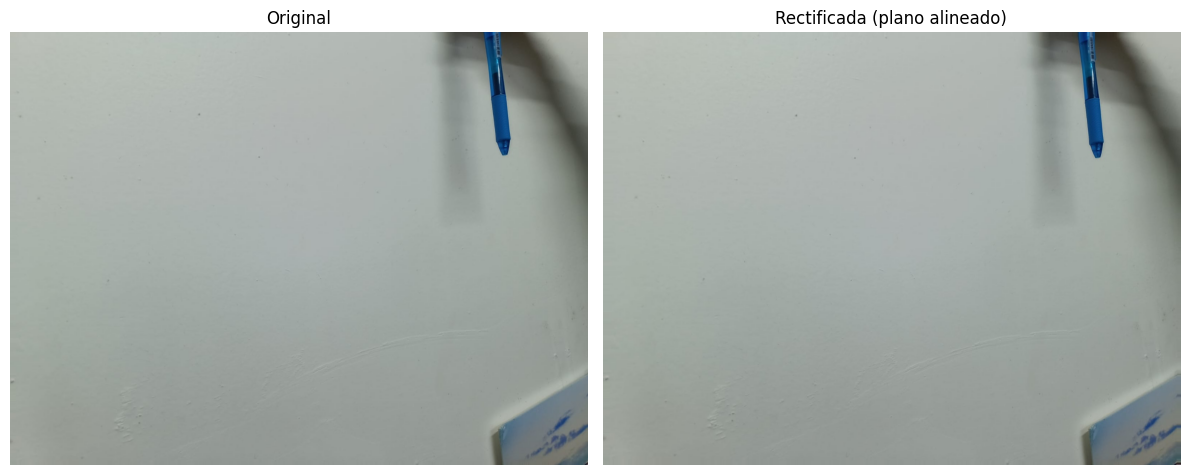

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_PATH = 'corregir5.jpg'

FORCE_RATIO = None   
DST_WIDTH   = 1000   

def order_corners(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    d = np.diff(pts, axis=1).ravel()
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(d)]
    bl = pts[np.argmax(d)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def warp_full_image(img, H):
    h_img, w_img = img.shape[:2]
    corners = np.array([[0,0],[w_img-1,0],[w_img-1,h_img-1],[0,h_img-1]], dtype=np.float32)
    corners_t = cv2.perspectiveTransform(corners[None, :, :], H)[0]
    min_xy = corners_t.min(axis=0)
    max_xy = corners_t.max(axis=0)
    Tx, Ty = -min_xy[0], -min_xy[1]
    T = np.array([[1,0,Tx],[0,1,Ty],[0,0,1]], dtype=np.float32)
    W = int(np.ceil(max_xy[0] - min_xy[0]))
    Hout = int(np.ceil(max_xy[1] - min_xy[1]))
    W = max(W, 1); Hout = max(Hout, 1)
    return cv2.warpPerspective(img, T @ H, (W, Hout),
                               flags=cv2.INTER_CUBIC,
                               borderMode=cv2.BORDER_REPLICATE)

# --- Cargar imagen ---
img = cv2.imread(IMG_PATH)
if img is None:
    raise FileNotFoundError(f"No se pudo cargar '{IMG_PATH}'.")

# --- Selección de 4 puntos (cualquier orden) ---
vis = img.copy()
points = []
def on_click(ev, x, y, flags, param):
    if ev == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x,y))
        cv2.circle(vis, (x,y), 6, (0,255,0), -1)
        cv2.imshow("Haz clic en 4 esquinas del MISMO plano", vis)

cv2.namedWindow("Haz clic en 4 esquinas del MISMO plano", cv2.WINDOW_NORMAL)
cv2.imshow("Haz clic en 4 esquinas del MISMO plano", vis)
cv2.setMouseCallback("Haz clic en 4 esquinas del MISMO plano", on_click)
cv2.waitKey(0); cv2.destroyAllWindows()
if len(points) != 4:
    raise SystemExit("❌ Debes seleccionar exactamente 4 puntos.")

# --- Ordenar TL, TR, BR, BL ---
tl, tr, br, bl = order_corners(points)

# --- Calcular ancho/alto "alineados" (promedio de lados opuestos) ---
def dist(a,b): return float(np.linalg.norm(a-b))
width  = (dist(tl, tr) + dist(bl, br)) * 0.5
height = (dist(tl, bl) + dist(tr, br)) * 0.5
width  = max(int(round(width)), 1)
height = max(int(round(height)), 1)

# --- (Opcional) forzar proporción exacta ---
if FORCE_RATIO is not None:
    ar_w, ar_h = FORCE_RATIO
    width = int(DST_WIDTH)
    height = max(int(round(width * (ar_h / float(ar_w)))), 1)

# --- Destino: rectángulo perfecto, ejes horizontales/verticales ---
dst_pts = np.array([[0,0],
                    [width-1,0],
                    [width-1,height-1],
                    [0,height-1]], dtype=np.float32)

src_pts = np.array([tl, tr, br, bl], dtype=np.float32)

# --- Homografía (endereza el plano seleccionado) ---
H = cv2.getPerspectiveTransform(src_pts, dst_pts)

# --- Warpear TODA la imagen con lienzo expandido ---
rectificada_full = warp_full_image(img, H)

# --- Mostrar ---
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(rectificada_full, cv2.COLOR_BGR2RGB)); plt.title("Rectificada (plano alineado)"); plt.axis('off')
plt.tight_layout(); plt.show()
